In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="7" color='red'>    <b>Epochs exploration</b>

In [2]:
IDs  = [11, 3, 4, 5, 6, 7, 15, 16]
path = 'C:/Users/willy/OneDrive/Documents/GitHub/Intent-to-interact/data/'

eeg = {'11': None, '3': None, '4': None, '5': None, '6': None, '7': None, '15': None, '16': None}
emg = {'11': None, '3': None, '4': None, '5': None, '6': None, '7': None, '15': None, '16': None}
eye = {'11': None, '3': None, '4': None, '5': None, '6': None, '7': None, '15': None, '16': None}

for id in IDs:
    
    eeg[str(id)] = pd.read_csv(path + str(id) + '/' + 
                                    f'data_s{id}_rp-win_-1-0_srate-250_modality-eeg.csv')
    emg[str(id)] = pd.read_csv(path + str(id) + '/' + 
                                    f'data_s{id}_rp-win_-1-0_srate-250_modality-emg.csv')
    #eye[str(id)] = pd.read_csv(path + str(id) + '/' + 
    #                                f'data_s{id}_rp-win_-1-0_srate-250_modality-eye.csv')

In [3]:
def eeg_plot(ID):
    
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

    sns.set_theme(style="ticks")
    sns.set_context("talk")

    electrodes = eeg[str(ID)].iloc[:,3:].mean(axis=1)
    electrode = 'Cz'

    # Plot the responses for different events and regions
    g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=eeg[str(ID)], legend=False)
    sns.despine()
    g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

    g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=eeg[str(ID)], legend=True)
    g2.set(xlabel='seconds', ylabel='\u03bcV', title='Averaged EEG signal at ' + electrode)

    # legend
    leg = g2.legend_
    new_title = 'Class'
    leg.set_title(new_title)
    plt.legend(loc='lower left')
    # replace labels
    new_labels = ['Pre-move', 'Idle']
    for t, l in zip(g2.legend_.texts, new_labels):
        t.set_text(l)

In [4]:
def emg_plot(ID):

    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

    sns.set_theme(style="ticks")
    sns.set_context("talk")
    electrode1 = 'Deltoid'
    electrode2 = 'Biceps'

    g = sns.lineplot(ax=axes[0], x="sample", y='EMG1',
             hue="rp_class", style="rp_class",
             data=emg[str(ID)])
    sns.despine()
    g.set(xlabel='seconds', ylabel='V', title='Average amplitude at '+ electrode1)

    g2 = sns.lineplot(ax=axes[1], x="sample", y='EMG2',
             hue="rp_class", style="rp_class",
             data=emg[str(ID)], legend=False)
    g2.set(xlabel='seconds', ylabel=None, title='Average amplitude at '+ electrode2)


    # legend
    leg = g.legend_
    new_title = 'Class'
    leg.set_title(new_title)
    # replace labels
    new_labels = ['Pre-move', 'Idle']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)

In [5]:
def eye_plot(ID):   
    
    sns.set_theme(style="ticks")
    sns.set_context("talk")

    # Plot the responses for different events and regions
    g = sns.lineplot(x="sample", y='GazeVel',
             hue="rp_class", style="rp_class",
             data=eye[str(ID)])
    sns.despine()
    g.set(xlabel='seconds', ylabel='speed unit', title='Gaze Velocity')

    # legend
    leg = g.legend_
    new_title = 'Class'
    leg.set_title(new_title)
    # replace labels
    new_labels = ['Pre-move', 'idle']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)

<font size="7" color='red'>    <b>Averaged between subjects</b>
    
Would be nice to average this to highlight the pre-movement signal in EEG and EMG.

However there's some requirement for EEG, the chosen electrode (FCz for instance) needs to be part of the 20 electrodes of the subjects, which is currently not the case.

In [5]:
eeg_all = pd.concat([eeg['11'], eeg['3'], eeg['4'], eeg['5'], eeg['6'], eeg['7'], eeg['15'],eeg['16']], ignore_index=True, axis = 0)
emg_all = pd.concat([emg['11'], emg['3'], emg['4'], emg['5'], emg['6'], emg['7'], emg['15'],emg['16']], ignore_index=True, axis = 0)

In [6]:
eeg_all['rp_class'] = eeg_all['rp_class'].replace([1], 3)
eeg_all['rp_class'] = eeg_all['rp_class'].replace([2], 1)

emg_all['rp_class']= emg_all['rp_class'].replace([1], 3)
emg_all['rp_class'] = emg_all['rp_class'].replace([2], 1)

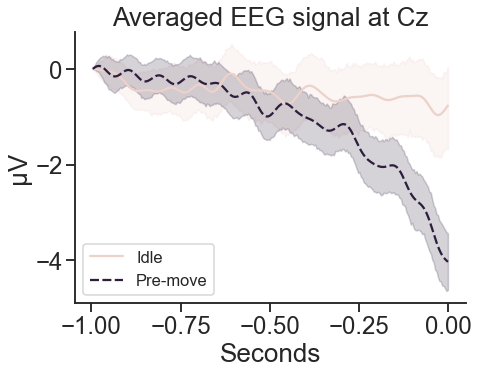

In [22]:
figure(figsize=(7,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrode = 'Cz'

# Plot the responses for different events and regions
#g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
#            hue="rp_class", style="rp_class",
#            data=eeg_all, legend=False)
sns.despine()
#g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g3 = sns.lineplot(x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=eeg_all, legend=True)

g3.set_title('Averaged EEG signal at ' + electrode, fontsize=26)
g3.set_xlabel('Seconds',fontsize=26)
g3.set_ylabel('\u03bcV',fontsize=26)
g3.tick_params(labelsize=24)
g3.set_xticks([-1, -0.75, -0.5, -0.25, 0])
sns.despine()
# legend
leg = g3.legend_
new_title = 'Class'
leg.set_title(new_title)
plt.legend(loc='lower left')
# replace labels
new_labels = ['Idle', 'Pre-move']
for t, l in zip(g3.legend_.texts, new_labels):
    t.set_text(l)
plt.setp(g3.get_legend().get_title(), fontsize='26')

plt.savefig("Average_EEG.svg", bbox_inches="tight")

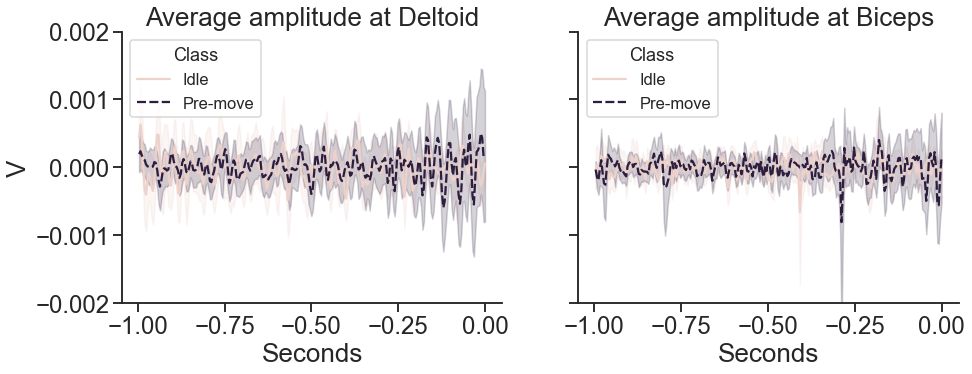

In [23]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))

sns.set_theme(style="ticks")
sns.set_context("talk")
sns.despine()
electrode1 = 'Deltoid'
electrode2 = 'Biceps'

g = sns.lineplot(ax=axes[0], x="sample", y='EMG1', hue="rp_class", style="rp_class", data=emg_all)
g.set_xlabel('Seconds',fontsize=26)
g.set_ylabel('V',fontsize=26)
g.tick_params(labelsize=24)
g.set_title('Average amplitude at '+ electrode1, fontsize=26)
#g.set(ylabel='V', title='Average amplitude at '+ electrode1)
g.legend(loc='upper left')

g2 = sns.lineplot(ax=axes[1], x="sample", y='EMG2', hue="rp_class", style="rp_class", data=emg_all, legend=True)
g2.set_xlabel('Seconds',fontsize=26)
g2.tick_params(labelsize=24)
g2.set_title('Average amplitude at '+ electrode2, fontsize=26)
#g2.set(ylabel=None, title='Average amplitude at '+ electrode2)
g2.legend(loc='upper left')

g.set_ylim((-0.002, 0.002))

# legend
leg = g.legend_
leg2= g2.legend_
new_title = 'Class'
leg.set_title(new_title)
leg2.set_title(new_title)

# replace labels
new_labels = ['Idle', 'Pre-move']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
for t, l in zip(g2.legend_.texts, new_labels):
    t.set_text(l)
    
plt.savefig("Average_EMG.svg", bbox_inches="tight")